# Example of using the orm classes

### Imports

In [81]:
from core.core import Project
from core.orm import BoreholeOrm, Base
from utils.io import boreholes_from_files
from striplog import Lexicon, Striplog, Interval, Component, Position, Decor, Legend
from striplog.utils import hex_to_rgb
from matplotlib.colors import ListedColormap
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import omfvista as ov
import pyvista as pv
import omf
from vtk import vtkX3DExporter
from IPython.display import HTML

In [83]:
from core.omf import Borehole3D, striplog_legend_to_omf_legend 

In [84]:
! rm ./tmp/test_orm_db.db

rm: impossible de supprimer './tmp/test_orm_db.db': Aucun fichier ou dossier de ce type


In [85]:
components = [Component({'lithology': 'siltstone', 'colour': 'grey'}),
              Component({'lithology': 'anhydrite'}),
              Component({'lithology': 'sandstone', 'grainsize': 'vf-f', 'colour': 'grey'}),
              Component({'lithology': 'dolomite'}),
              Component({'lithology': 'siltstone', 'colour': 'red'}),
              Component({'lithology': 'limestone'})]
list_of_decors=[]
hatches = ['=', 'x', '.', 's', '=', 'b']
colours = ['#888888', '#882222', '#AAAAAA', '#CC22CC', '#CC2222', '#2222CC']
for i in range(len(components)):
    d = {'color': colours[i],
         'hatch': hatches[i],
         'component': components[i],
         'width': 3}
    decor = Decor(d)
    list_of_decors.append(decor)
legend = Legend(list_of_decors)

In [86]:
omf_legend, omf_cmap = striplog_legend_to_omf_legend(legend)

In [87]:
bh3d = Borehole3D(legend=legend)

Pay attention that default intervals are actually used !

Borehole geometry created successfully !


<AxesSubplot:>

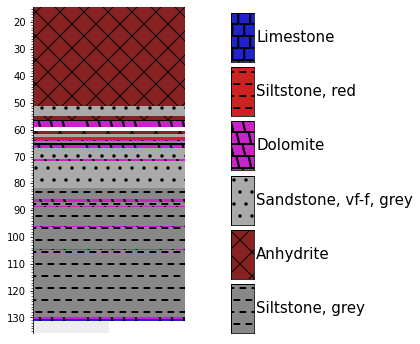

In [88]:
fix, ax = plt.subplots(ncols=2, figsize=(6,6))
bh3d.plot(legend=legend, ax=ax[0])
bh3d.legend.plot(ax=ax[1])

In [89]:
b = bh3d.intervals[0].base

In [90]:
bh3d.geometry.geometry.vertices.array

Vector3Array([[   0.        ,    0.        ,  -14.3       ],
              [   0.        ,    0.        ,  -51.24117647],
              [   0.        ,    0.        ,  -51.24117647],
              [   0.        ,    0.        ,  -54.81764706],
              [   0.        ,    0.        ,  -54.81764706],
              [   0.        ,    0.        ,  -56.55882353],
              [   0.        ,    0.        ,  -56.55882353],
              [   0.        ,    0.        ,  -58.86470588],
              [   0.        ,    0.        ,  -60.46470588],
              [   0.        ,    0.        ,  -61.45294118],
              [   0.        ,    0.        ,  -61.45294118],
              [   0.        ,    0.        ,  -62.77058824],
              [   0.        ,    0.        ,  -62.77058824],
              [   0.        ,    0.        ,  -63.94705882],
              [   0.        ,    0.        ,  -63.94705882],
              [   0.        ,    0.        ,  -64.37058824],
              [   0.    

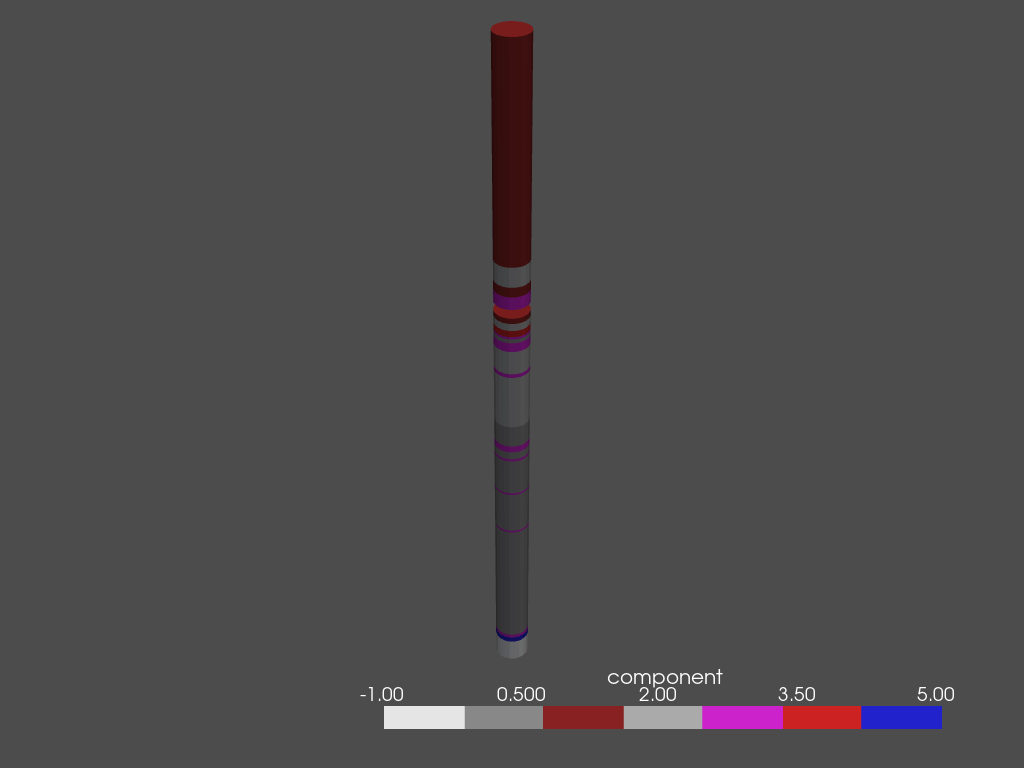

In [91]:
bh3d.plot3d()

In [92]:
def plot3d(x3d=False):
    omf_legend, omf_ = striplog_legend_to_omf_legend(bh.legend)
    pl = pv.Plotter()
    seg = ov.line_set_to_vtk(bh.geometry)
    seg.set_active_scalars('component')
    ov.lineset.add_data(seg, bh.geometry.data)
    pl.add_mesh(seg.tube(radius=3), cmap=bh.omf_cmap)
    if not x3d:
        pl.show()
    else:
        writer = vtkX3DExporter()
        writer.SetInput(pl.renderer.GetRenderWindow())
        filename = f'bh_{bh.name:s}.x3d' #the BH's name (empty!!!)
        writer.SetFileName(filename)
        writer.Update()
        writer.Write()
        x3d_html = f'<html>\n<head>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge"/>\n' \
                    '<title>X3D scene</title>\n <p>' \
                    '<script type=\'text/javascript\' src=\'http://www.x3dom.org/download/x3dom.js\'> </script>\n' \
                    '<link rel=\'stylesheet\' type=\'text/css\' href=\'http://www.x3dom.org/download/x3dom.css\'/>\n' \
                    '</head>\n<body>\n<p>\n For interaction, click in the view and press "a" to see the whole scene. For more info on interaction,' \
                    ' please read  <a href="https://doc.x3dom.org/tutorials/animationInteraction/navigation/index.html">the docs</a>  \n</p>\n' \
                    '<x3d width=\'968px\' height=\'600px\'>\n <scene>\n' \
                    '<viewpoint position="-1.94639 1.79771 -2.89271" orientation="0.03886 0.99185 0.12133 3.75685">' \
                    '</viewpoint>\n <Inline nameSpaceName="Borehole" mapDEFToID="true" url="'+filename+'" />\n' \
                    '</scene>\n</x3d>\n</body>\n</html>\n'
        return HTML(x3d_html)

In [93]:
print(bh3d.name)
bh3d.plot3d(x3d=True)

## omf project creation

In [175]:
# must make a class project after !!!
class omf_project(omf.Project, Borehole3D):
    """
    OMF project where several boreholes can be added and display
    
    bh_elem_list : []
    """
    
    def __init__(self, proj_name, elem_list=None, descr='', author=''):
        
        self.name=proj_name
        self.description=descr
        self.author=author
        
        if elem_list is None:
            print('No element given! A default borehole geometry has been used ! ')
            self.elements= [omf.LineSetElement(
                name='default line',
                geometry=omf.LineSetGeometry(vertices=np.random.rand(100, 3),
                                             segments=np.floor(np.random.rand(50, 2)*100).astype(int)
                ),
                
                data=[
                    omf.ScalarData(name='rand vert data',
                                   array=np.random.rand(100),
                                   location='vertices'
                                  ),
                    omf.ScalarData(
                        name='rand segment data',
                        array=np.random.rand(50),
                        location='segments'
                    )
                ],
                
                color='#0000FF' #or 'red'
            )]
        else:
            self.add_borehole(elem_list=elem_list)
            

        #make a @property to create automatically a lisible project_Id, but we'll be conservated since created
    def save(self):
        omf.OMFWriter(proj, f'{self.name}.omf')
        
    def add_borehole(self, elem_list):
        for bh in elem_list:
            print(type(bh))
            self.elements.append(bh)
        
        assert self.validate()
        
    def plot3d(self):
        return ov.project_to_vtk(self).plot()
   

In [176]:
p=omf_project('BH_proj_test', [bh3d.geometry, bh3d.geometry]) 
print(type(p.elements[0]))
p.elements[0]

<class 'omf.lineset.LineSetElement'>
<class 'omf.lineset.LineSetElement'>
<class 'omf.lineset.LineSetElement'>


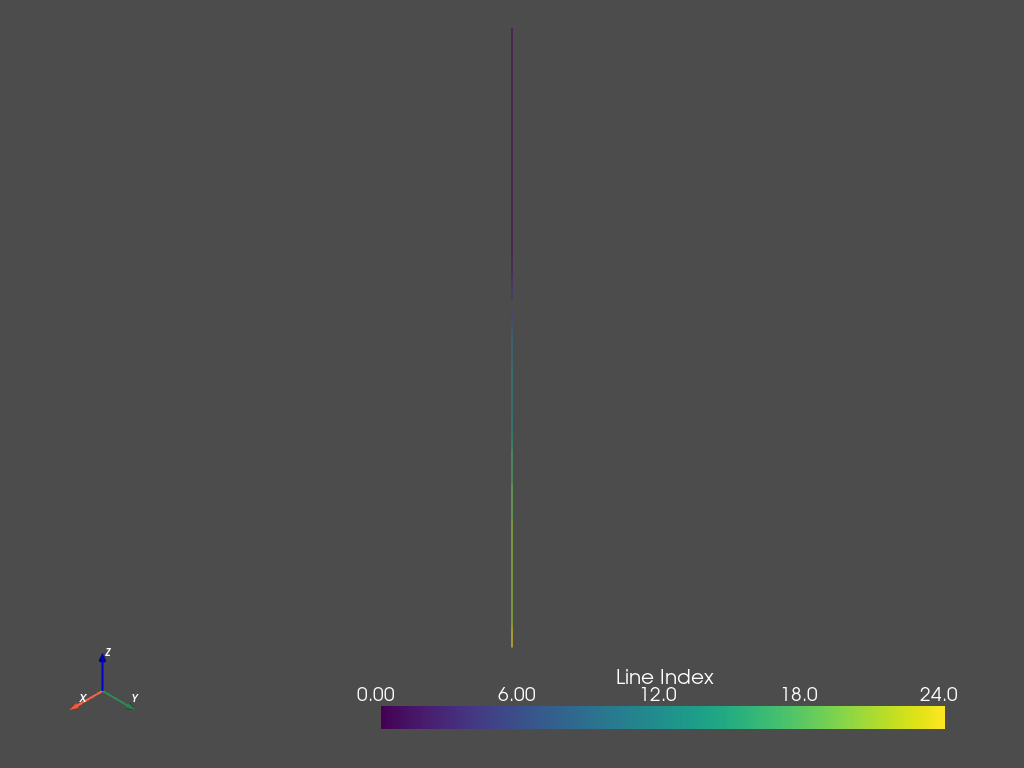

[(135.62717671268996, 135.62717671268996, 60.52717671268995),
 (0.0, 0.0, -75.10000000000001),
 (0.0, 0.0, 1.0)]

In [177]:
p.plot3d()

<class 'omf.lineset.LineSetElement'>


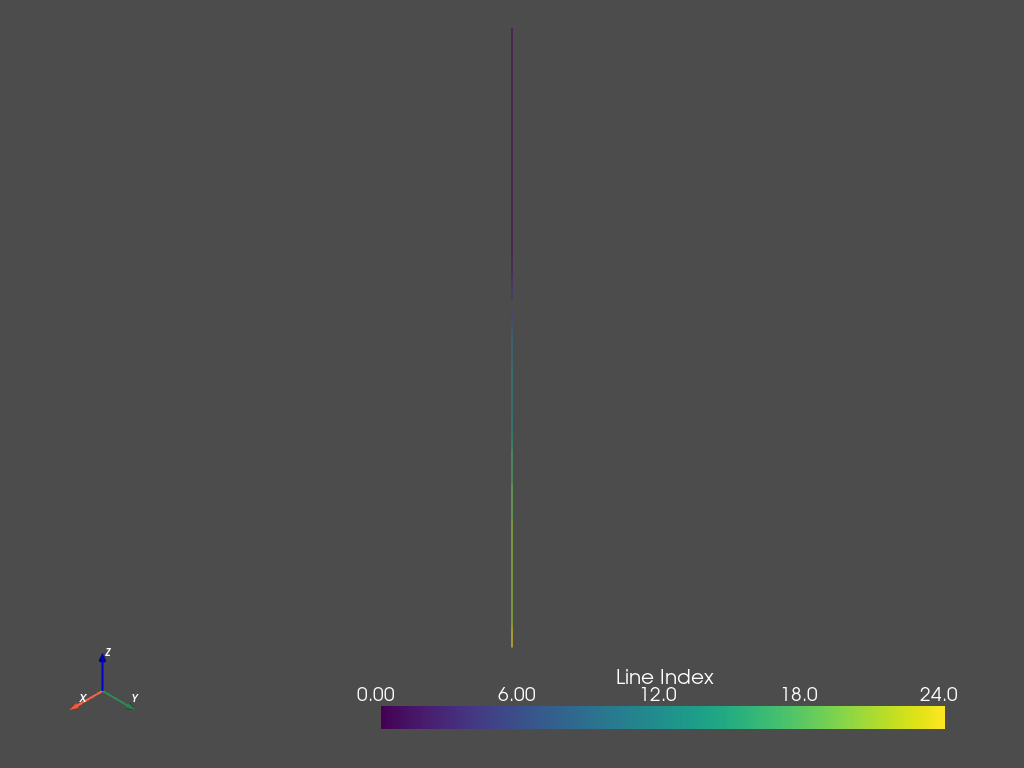

[(135.62717671268996, 135.62717671268996, 60.52717671268995),
 (0.0, 0.0, -75.10000000000001),
 (0.0, 0.0, 1.0)]

In [174]:
p.add_borehole([bh3d.geometry])
p.plot()


In [26]:
bh3d.intervals[0].top

upper,14.3
middle,14.3
lower,14.3


###### ------------------ test --------------------------------

In [ ]:
omf_legend, omf_ = striplog_legend_to_omf_legend(self.legend)
        pl = pv.Plotter()
        seg = ov.line_set_to_vtk(self.geometry)
        seg.set_active_scalars('component')
        ov.lineset.add_data(seg, self.geometry.data)
        pl.add_mesh(seg.tube(radius=3), cmap=self.omf_cmap)
        
        if not x3d:
            pl.show()
        else:
            writer = vtkX3DExporter()
            writer.SetInput(pl.renderer.GetRenderWindow())
            filename = f'BH_{self.name:s}.x3d'
            writer.SetFileName(filename)
            writer.Update()
            writer.Write()
            x3d_html = f'<html>\n<head>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge"/>\n' \
                       '<title>X3D scene</title>\n <p>' \
                       '<script type=\'text/javascript\' src=\'http://www.x3dom.org/download/x3dom.js\'> </script>\n' \
                       '<link rel=\'stylesheet\' type=\'text/css\' href=\'http://www.x3dom.org/download/x3dom.css\'/>\n' \
                       '</head>\n<body>\n<p>\n For interaction, click in the view and press "a" to see the whole scene. For more info on interaction,' \
                       ' please read  <a href="https://doc.x3dom.org/tutorials/animationInteraction/navigation/index.html">the docs</a>  \n</p>\n' \
                       '<x3d width=\'968px\' height=\'600px\'>\n <scene>\n' \
                       '<viewpoint position="-1.94639 1.79771 -2.89271" orientation="0.03886 0.99185 0.12133 3.75685">' \
                       '</viewpoint>\n <Inline nameSpaceName="Borehole" mapDEFToID="true" url="' + filename + '" />\n' \
                                                                                                              '</scene>\n</x3d>\n</body>\n</html>\n'
            return HTML(x3d_html)

In [64]:
proj = omf.Project(
    name='Test project',
    description='Just some assorted elements'
)

In [65]:
def define_line(name, elm_type, color):
    
    if elm_type=='line':
        element= omf.LineSetElement(
            name=name,
            geometry=omf.LineSetGeometry(
                vertices=np.random.rand(100, 3),
                segments=np.floor(np.random.rand(50, 2)*100).astype(int)
            ),
            data=[
                omf.ScalarData(
                    name='rand vert data',
                    array=np.random.rand(100),
                    location='vertices'
                ),
                omf.ScalarData(
                    name='rand segment data',
                    array=np.random.rand(50),
                    location='segments'
                )
            ],
            color=color #'#0000FF'
        )
    
    elif elm_type=='surface':
        
        element= omf.SurfaceElement(
            name='trisurf',
            geometry=omf.SurfaceGeometry(
                vertices=np.random.rand(100, 3),
                triangles=np.floor(np.random.rand(50, 3)*100).astype(int)
            ),
            data=[
                omf.ScalarData(
                    name='rand vert data',
                    array=np.random.rand(100),
                    location='vertices'
                ),
                omf.ScalarData(
                    name='rand face data',
                    array=np.random.rand(50),
                    location='faces'
                )
            ],
            color=color #[100, 200, 200]
        )
    else:
        print("Error! element type must be 'line' or 'surface' !")

    
    return element

In [66]:
lin=define_line('Line_1', 'line', 'red')
surf=define_line('Surface_1', 'surface','blue')

In [67]:
proj.elements = [lin, surf]

assert proj.validate()

omf.OMFWriter(proj, 'omf_proj_test.omf')
file='omf_proj_test.omf'

In [105]:
# Read all elements
reader= omf.OMFReader(file)
proj_all=reader.get_project() 
proj_all.elements

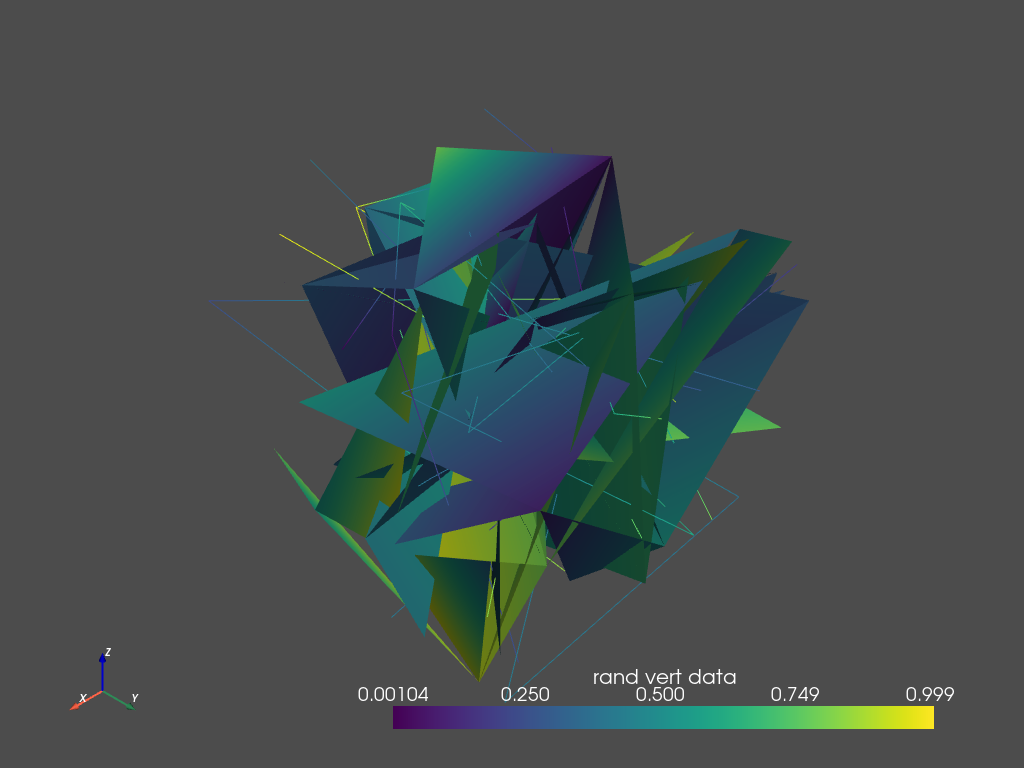

[(2.3866226733908977, 2.3896436839993576, 2.3850453288804245),
 (0.4991588975290889, 0.5021799081375492, 0.49758155301861545),
 (0.0, 0.0, 1.0)]

In [157]:
# Read all lineSetElements:
proj_piece = omf.OMFReader(file).get_project_overview()
uids_to_import = [element.uid for element in proj_piece.elements if isinstance(element, omf.lineset.LineSetElement)]
proj_piece = reader.get_project(uids_to_import)
proj_piece.elements

[]

In [161]:
#file='omf_dev/website_test_file.omf' 
file='omf_proj_test.omf'

# Read all elements with omf-vista
proj_ov = ov.load_project(file)
proj_ov

MultiBlock (0x7f3c1c631e88)
  N Blocks:	2
  X Bounds:	0.020, 0.985
  Y Bounds:	0.010, 0.998
  Z Bounds:	0.004, 0.997

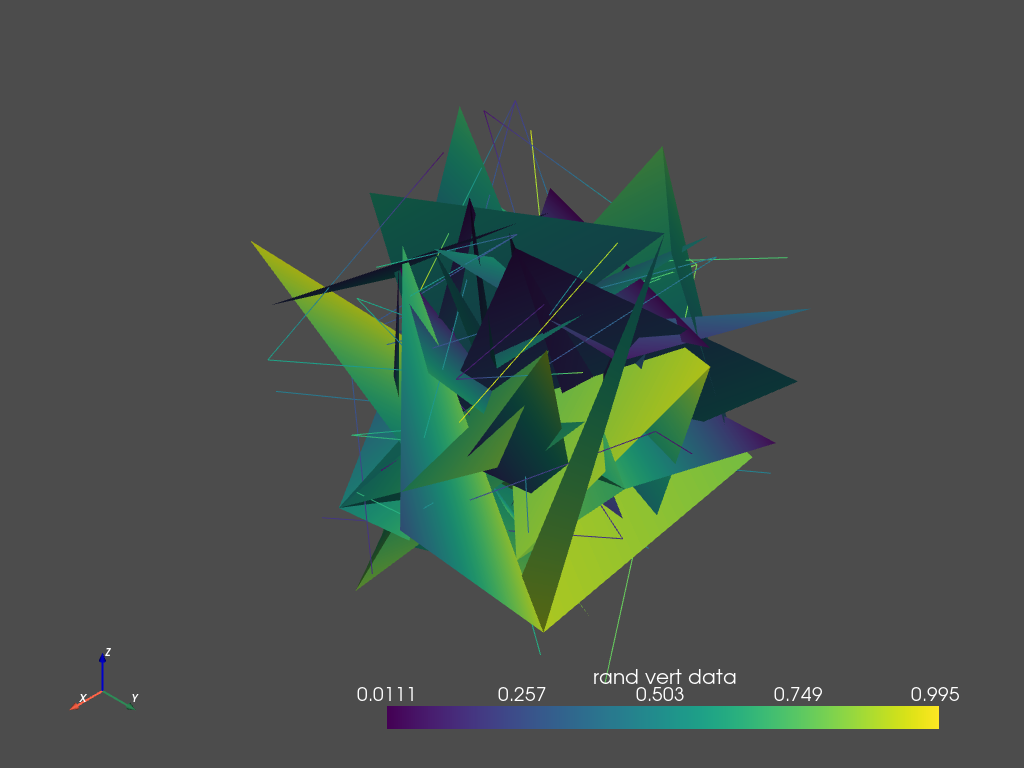

[(2.399057336511845, 2.4006163625801675, 2.397313593294373),
 (0.5024003060799718, 0.5039593321482948, 0.5006565628625002),
 (0.0, 0.0, 1.0)]

In [162]:
proj_ov.plot()

##### ---------------end Test -------------------------------

### Create the db engine and the database structure

In [ ]:
engine = create_engine('sqlite:///../examples/tmp/test_orm_db.db', echo=True)

In [ ]:
Base.metadata.create_all(engine)

### Create the objects from text files (las, csv, txt)

In [ ]:
lexicon = Lexicon.default()

In [ ]:
borehole_dict = {'F01':'../data/test.las', 'F02':'../data/test.csv'} # boreholes to insert into the db

In [ ]:
boreholes, components = boreholes_from_files(borehole_dict=borehole_dict)

In [ ]:
boreholes

### Create the ORM session

In [ ]:
Session = sessionmaker(bind=engine)
session = Session()

### Create the ORM project

In [ ]:
p = Project(session)

### Add boreholes into the database

In [ ]:
for bh in boreholes:
    p.add_borehole(bh)

In [ ]:
p.boreholes[0].id

In [ ]:
p.boreholes[1].id='F33'

In [ ]:
p.boreholes[1].id

In [ ]:
p.commit()

In [ ]:
p.boreholes[0].intervals[0].description

In [ ]:
session.close()

### Test linking orm and omf : 
For now IntervalOrm do not have a base and a top -> adding them to the intervals retrieved from the boreholes in the sqlite database

In [ ]:
bh3d.intervals[0].base.z


In [ ]:
itvls = list(p.boreholes[0].intervals.values())

In [ ]:
z=0.
dz=10.
itvls_list = []
for itvl in itvls:
    comp = Component(lexicon.get_component(itvl.description))
    top = Position(x=0., y=10., middle=z)
    z += dz
    base = Position(x=0., y=10., middle=z)
    itvls_list.append(Interval(top=top, base=base, components=[comp], description=itvl.description, lexicon=lexicon))

In [ ]:
bh3d.intervals[0]

In [ ]:
itv = Interval(top=top, base=base, components=[comp], description=itvl.description, lexicon=lexicon)

In [ ]:
itv

In [ ]:
type(bh3d.intervals[0])

In [ ]:
bh3d_2 = Borehole3D(itvls_list)

In [ ]:
bh3d_2.plot3d()